In [1]:
import matplotlib.pyplot as plt
import numpy as np
from article import *

In [2]:
article1 = "10.1038/s41467-023-43444-3" # health
article2 = "10.1038/s41467-018-04608-8" # zou
article3 = "10.1038/s41467-023-42766-6" # cats
article4 = "10.1038/s41467-017-00516-5" # Ahn et al.
article5 = "10.1038/s41467-019-11343-1" # Jelena

articles = [filename_from_DOI(doi=doi) for doi in [article1,article2,article3,article4,article5]]
article_labels = [f"article {i+1}" for i in range(len(articles))]
article_labels = ["medicine","bioinformatics","ecology","chemistry","physics/EE"]

def reset_articles():
    return [filename_from_DOI(doi=doi) for doi in [article1,article2,article3,article4,article5]]

In [3]:
lang_dict = load_langs()['translation']
langs = lang_dict.keys()
langs_display = list(langs)
langs_display[1] = "Chinese (simp.)"
langs_display[2] = "Chinese (trad.)"

In [4]:
def get_json(fn):
    d = {}
    with open(fn, "r") as infile:
        d = json.load(infile)
    return d

def save_json(d, fn):
    with open(fn, "w") as outfile:
        json.dump(d, outfile, indent=4)

def incorrect(graded_answers):
    inc_num, inc_val = [], []
    for i in graded_answers.keys():
        if not graded_answers[i][1]:
            inc_num.append(i)
            inc_val.append(graded_answers[i][0])
    return inc_num, inc_val

In [5]:
def to_prune(folder, cutoff):
    # if *cutoff* of all languages get a specific question wrong in the quiz, prune it.
    # does not edit files; just returns which questions to ignore
    incorrect_count, to_prune = {}, []
    for l in langs:
        #print(l, article)
        answers = get_json(folder+f"/QnA_{lang_dict[l]}_answers.json")
        for q_num in answers.keys():
            if q_num not in incorrect_count.keys():
                incorrect_count[q_num] = 0
            if not answers[q_num][1]:
                incorrect_count[q_num] += 1
    for q_num in incorrect_count.keys():
        if incorrect_count[q_num]/len(langs) > cutoff:
            to_prune.append(q_num)
    return to_prune

def pruned(dict, to_prune):
    pruned = {}
    for key, val in zip(dict.keys(),dict.values()):
        if key not in to_prune:
            pruned[key] = val
    return pruned


def plot_quiz(folders, colors, plot_avg=False, legend=True, prune=1.1):
    fig, ax = plt.subplots(1,1, figsize=(10,3))
    x = np.linspace(0,1,len(langs))
    all_avgs = []
    q_length = 0 # init
    for folder, cs in zip(folders,colors):
        ys = []
        for article in articles:
            fd = f"FullTexts/{article}/{folder}"
            y = []

            pruned_qs = to_prune(fd, prune)
            for l in langs:
                #print(l, article)
                answers = pruned(get_json(fd+f"/QnA_{lang_dict[l]}_answers.json"), pruned_qs)
                q_length = len(answers.keys())
                incorrect_nums, incorrect_answers = incorrect(answers)
                y.append(100-int((len(incorrect_nums)/q_length)*100))
            ys.append(y)


        avgs = [100-sum([y[i] for y in ys])/len(ys) for i in range(len(x))]

        # sorted_x = [a for (b,a) in sorted(zip(avgs,x), key=lambda pair: pair[0])]
        sorted_ys = [[a for (b,a) in sorted(zip(avgs,y), key=lambda pair: pair[0])] for y in ys]
        sorted_langs_display = [a for (b,a) in sorted(zip(avgs,langs_display), key=lambda pair: pair[0])]
        sorted_avgs = [100 - a for a in sorted(avgs)]
        # sorted_ys = ys
        # sorted_langs_display = langs_display

        print(sorted_langs_display)
        print(sorted_avgs)

        if all_avgs == []:
            all_avgs = sorted_avgs
        else:
            all_avgs = [(a+b)/2 for a,b in zip(all_avgs, sorted_avgs)]

        bar_width = 0.007
        colors = cs(np.linspace(0.4,0.65,len(ys)))
        for i in range(len(ys)):
            alpha = 1
            if len(folders) > 1:
                alpha = 0.8
            ax.bar(x + bar_width*(i-len(ys)//2), sorted_ys[i], bar_width, color=colors[i], alpha=alpha, label=article_labels[i]) 
    if plot_avg:
        # ax.bar(x, sorted_avgs, bar_width*len(ys), color='None', alpha=1, edgecolor='black', linewidth=0.5)
        # ax.bar(x, sorted_avgs, bar_width*len(ys), edgecolor='black')
        plt.plot(x, all_avgs, color="crimson", alpha=0.7, lw=2.5)

    # Set number of ticks for x-axis
    ax.set_xticks(x)
    ax.set_ylim([0,100+1])
    ax.set_xlim([min(x)-bar_width*(len(articles)//2+1),max(x)+bar_width*(len(articles)//2)])
    # Set ticks labels for x-axis
    ax.set_xticklabels(sorted_langs_display, rotation=70, fontsize=10)
    ax.set_ylabel('correct (%)')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_title(f"{q_length} question quiz")
    if legend:
        ax.legend(loc="lower left", fontsize=8)
    plt.show()


# analyze question number incorrect repetitions

def plot_q_stats(folder, color):
    fig, ax = plt.subplots(1,1, figsize=(10,3)) 
    q_length = int(folder[:2])
    x, ys = np.array([n+1 for n in range(q_length)]), [[0 for _ in range(q_length)] for _ in range(len(articles))]
    for i in range(len(articles)):
        article = articles[i]
        fd = f"FullTexts/{article}/{folder}"
        for l in langs:
            answers = get_json(fd+f"/QnA_{lang_dict[l]}_answers.json")
            incorrect_nums, incorrect_answers = incorrect(answers)
            incorrect_nums = [int(n)-1 for n in incorrect_nums]
            for n in incorrect_nums:
                ys[i][n] += 1

    bar_width = 0.2
    colors = color(np.linspace(0.2,0.8,len(ys)))
    for i in range(len(ys)):
        ax.bar(x + bar_width*(i-len(ys)//2), ys[i], bar_width, color=colors[i], label=article_labels[i]) 

    print([float(max(np.array(y)/len(langs))) for y in ys])

    ax.set_xticks(x)
    yticks = [n for n in range(len(langs)+1) if n%2==0]
    ax.set_yticks(yticks)
    ax.set_ylim([0,max(yticks)])
    ax.set_xlim([min(x)-bar_width*(len(ys)//2+1),max(x)+bar_width*(len(ys)//2)])
    # Set ticks labels for x-axis
    ax.set_xticklabels(x, rotation=70, fontsize=10)
    ax.set_yticklabels(yticks, fontsize=10)
    ax.set_xlabel('question #')
    ax.set_ylabel('errors (all languages)')
    ax.set_title(f"{q_length} question quiz")
    ax.legend(loc="upper left", fontsize=6)
    plt.show()

['Chinese (trad.)', 'German', 'Bengali', 'Italian', 'English', 'Chinese (simp.)', 'French', 'Korean', 'Dutch', 'Danish', 'Malay', 'Japanese', 'Hindi', 'Telugu', 'Swedish', 'Hebrew', 'Serbian', 'Urdu', 'Marathi', 'Gujarati', 'Spanish', 'Tamil']
[100.0, 100.0, 100.0, 100.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 97.0, 97.0, 97.0, 97.0, 94.0]


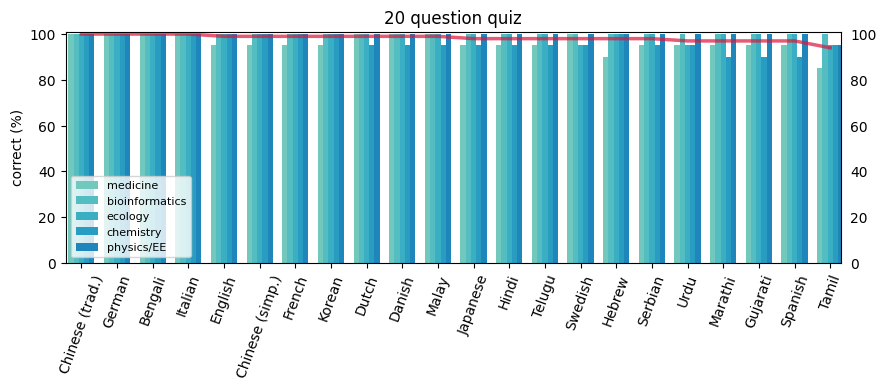

['English', 'Chinese (trad.)', 'Italian', 'German', 'Bengali', 'Dutch', 'Danish', 'Serbian', 'Chinese (simp.)', 'Japanese', 'Urdu', 'Marathi', 'Hebrew', 'French', 'Korean', 'Hindi', 'Gujarati', 'Swedish', 'Tamil', 'Telugu', 'Spanish', 'Malay']
[100.0, 100.0, 100.0, 99.0, 99.0, 99.0, 99.0, 99.0, 98.0, 98.0, 98.0, 98.0, 98.0, 97.0, 97.0, 97.0, 97.0, 97.0, 96.0, 96.0, 96.0, 96.0]


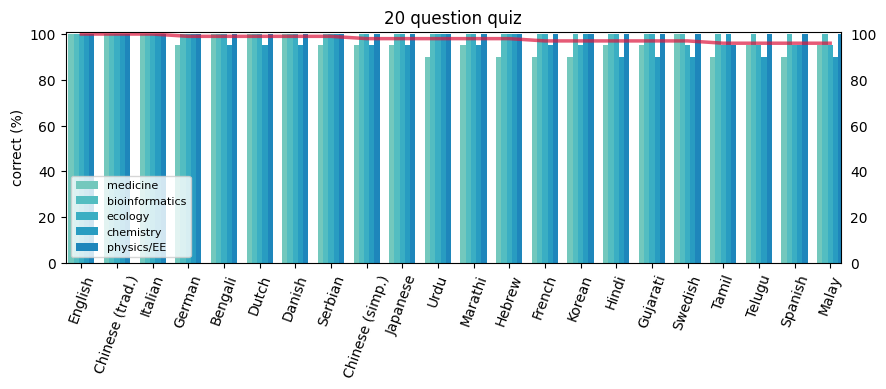

['English', 'German', 'French', 'Bengali', 'Italian', 'Dutch', 'Swedish', 'Hebrew', 'Malay', 'Serbian', 'Chinese (simp.)', 'Korean', 'Japanese', 'Spanish', 'Chinese (trad.)', 'Hindi', 'Danish', 'Urdu', 'Telugu', 'Marathi', 'Gujarati', 'Tamil']
[97.6, 97.6, 97.6, 97.6, 97.6, 97.6, 97.6, 97.6, 97.6, 97.6, 97.2, 97.2, 96.8, 96.8, 96.4, 96.4, 96.4, 95.6, 95.2, 94.8, 94.4, 92.0]


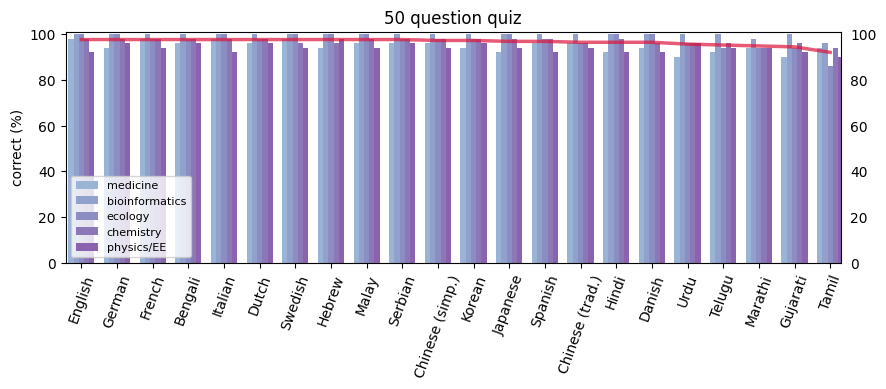

['Serbian', 'English', 'German', 'French', 'Bengali', 'Italian', 'Spanish', 'Dutch', 'Danish', 'Swedish', 'Hebrew', 'Chinese (simp.)', 'Chinese (trad.)', 'Japanese', 'Korean', 'Hindi', 'Malay', 'Urdu', 'Gujarati', 'Marathi', 'Telugu', 'Tamil']
[97.6, 97.2, 97.2, 97.2, 97.2, 97.2, 97.2, 97.2, 97.2, 96.8, 96.8, 96.4, 96.4, 96.0, 96.0, 96.0, 96.0, 94.8, 94.8, 94.4, 94.4, 90.0]


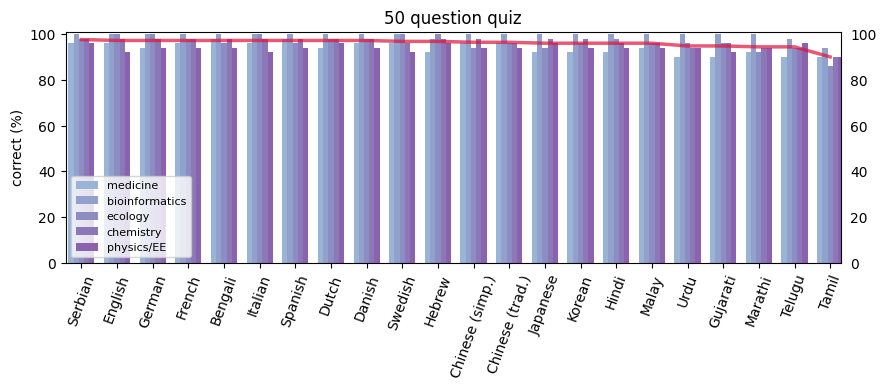

In [609]:
# 20 questions @ temp=0
# Translated questions @ temp=0
# Quiz @ temp=0,1

plot_quiz(["20q_temp0/temp0"], [plt.cm.YlGnBu], plot_avg=True)
plot_quiz(["20q_temp0/temp1"], [plt.cm.YlGnBu], plot_avg=True)
plot_quiz(["50q_temp1/temp0"], [plt.cm.BuPu], plot_avg=True)
plot_quiz(["50q_temp1/temp1"], [plt.cm.BuPu], plot_avg=True)

['English', 'French', 'Italian', 'Swedish', 'Malay', 'Chinese (simp.)', 'German', 'Dutch', 'Serbian', 'Japanese', 'Korean', 'Bengali', 'Spanish', 'Hebrew', 'Chinese (trad.)', 'Hindi', 'Danish', 'Urdu', 'Telugu', 'Marathi', 'Gujarati', 'Tamil']
[99.6, 99.6, 99.6, 99.6, 99.6, 99.2, 99.2, 99.2, 99.2, 98.8, 98.8, 98.8, 98.8, 98.8, 98.4, 98.4, 98.4, 97.2, 97.2, 96.4, 96.4, 93.6]


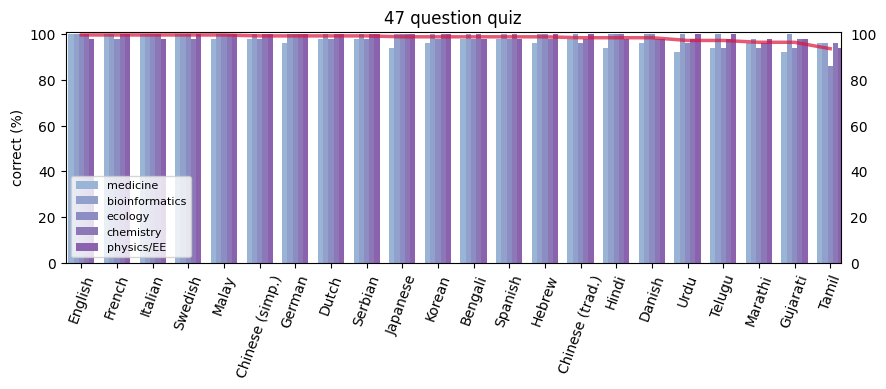

['English', 'German', 'French', 'Italian', 'Serbian', 'Spanish', 'Dutch', 'Swedish', 'Danish', 'Chinese (trad.)', 'Bengali', 'Hebrew', 'Chinese (simp.)', 'Korean', 'Malay', 'Japanese', 'Hindi', 'Gujarati', 'Urdu', 'Marathi', 'Telugu', 'Tamil']
[99.2, 99.2, 99.2, 99.2, 99.2, 98.8, 98.8, 98.8, 98.8, 98.4, 98.4, 98.4, 98.0, 98.0, 98.0, 97.6, 97.6, 96.8, 96.4, 96.0, 96.0, 91.6]


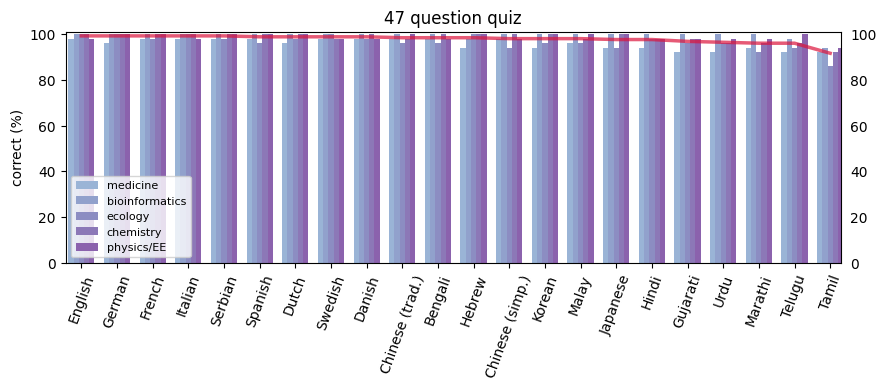

In [610]:
prune = 0.7
# plot_quiz(["20q_temp0/temp0"], [plt.cm.YlGnBu], plot_avg=True, prune=prune)
# plot_quiz(["20q_temp0/temp1"], [plt.cm.BuPu], plot_avg=True, prune=prune)
plot_quiz(["50q_temp1/temp0"], [plt.cm.BuPu], plot_avg=True, prune=prune)
plot_quiz(["50q_temp1/temp1"], [plt.cm.BuPu], plot_avg=True, prune=prune)

[0.5454545454545454, 0.0, 0.09090909090909091, 0.4090909090909091, 0.045454545454545456]


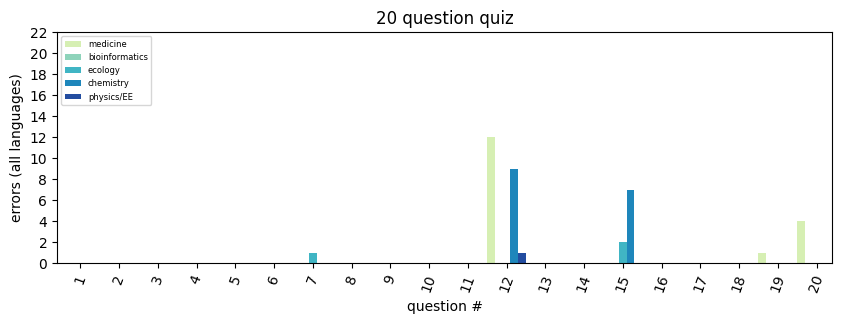

[0.5454545454545454, 0.0, 0.18181818181818182, 0.45454545454545453, 0.045454545454545456]


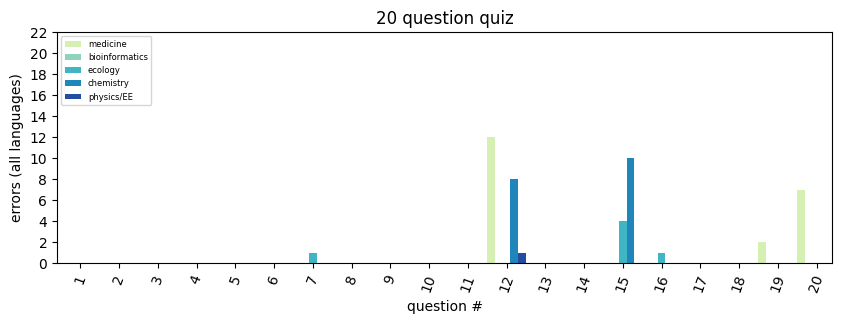

[1.0, 0.045454545454545456, 0.5, 1.0, 0.8636363636363636]


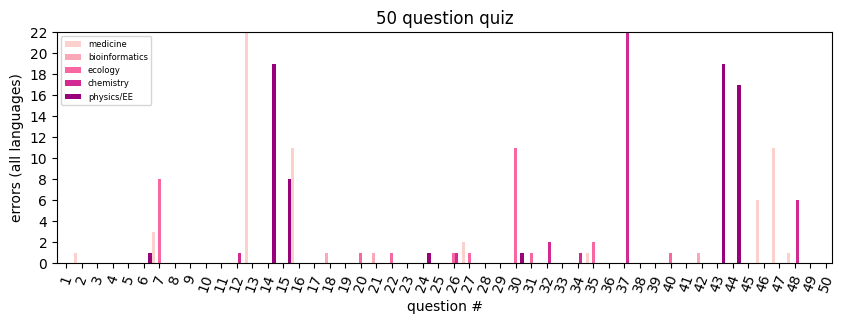

[0.9090909090909091, 0.09090909090909091, 0.4090909090909091, 1.0, 0.8636363636363636]


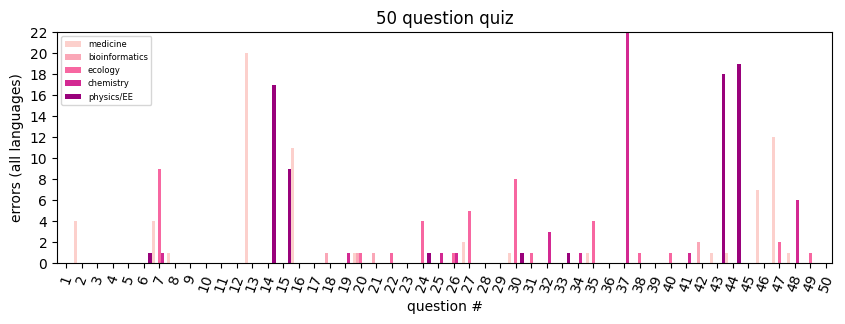

In [606]:
plot_q_stats("20q_temp0/temp0", plt.cm.YlGnBu)
plot_q_stats("20q_temp0/temp1", plt.cm.YlGnBu)
plot_q_stats("50q_temp1/temp0", plt.cm.RdPu)
plot_q_stats("50q_temp1/temp1", plt.cm.RdPu)

In [611]:
# plot_quiz(["20q_temp0/temp0","20q_temp0/temp1"], [plt.cm.Greens, plt.cm.Blues], plot_avg=True)
# plot_quiz(["50q_temp1/temp0","50q_temp1/temp1"], [plt.cm.Oranges, plt.cm.Reds], plot_avg=True)

In [ ]:
# 20 questions @ temp=0
# Translated questions @ temp=0
# Quiz @ temp=0,1
articles = [articles[0]]
article_labels = [article_labels[0]]
plot_quiz(["20q_temp0/temp0","20q_temp0/temp0_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
plot_quiz(["20q_temp0/temp1","20q_temp0/temp1_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
plot_quiz(["50q_temp1/temp0","50q_temp1/temp0_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
plot_quiz(["50q_temp1/temp1","50q_temp1/temp1_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)

In [ ]:
# 20 questions @ temp=0
# Translated questions @ temp=0
# Quiz @ temp=0,1
articles = reset_articles()
articles = [articles[3]]
article_labels = [article_labels[3]]
plot_quiz(["20q_temp0/temp0","20q_temp0/temp0_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
plot_quiz(["20q_temp0/temp1","20q_temp0/temp1_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
plot_quiz(["50q_temp1/temp0","50q_temp1/temp0_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
plot_quiz(["50q_temp1/temp1","50q_temp1/temp1_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
reset_articles()

['German', 'Danish', 'English', 'Chinese (trad.)', 'Japanese', 'Bengali', 'Italian', 'Dutch', 'Korean', 'Hebrew', 'Spanish', 'French', 'Swedish', 'Urdu', 'Serbian', 'Hindi', 'Gujarati', 'Malay', 'Chinese (simp.)', 'Marathi', 'Tamil', 'Telugu']
[93.0, 91.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 89.0, 89.0, 88.0, 87.0, 87.0, 86.0, 86.0, 85.0, 84.0, 84.0, 83.0, 83.0, 81.0, 77.0]


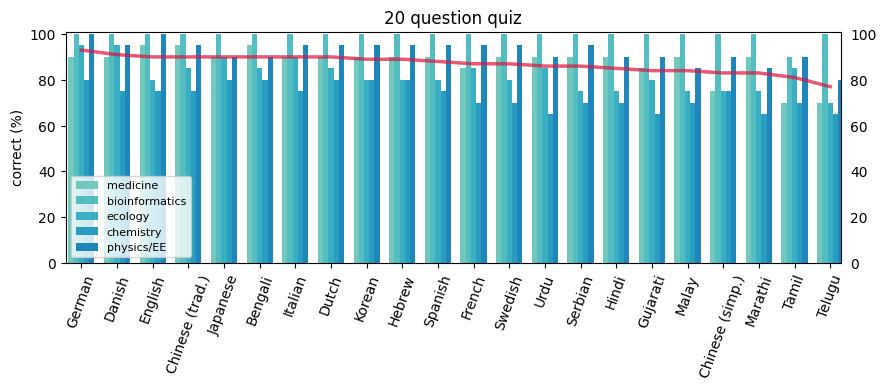

['Spanish', 'Japanese', 'Italian', 'Dutch', 'Serbian', 'Swedish', 'Danish', 'Chinese (trad.)', 'Hebrew', 'English', 'Chinese (simp.)', 'German', 'French', 'Bengali', 'Korean', 'Malay', 'Hindi', 'Gujarati', 'Tamil', 'Urdu', 'Marathi', 'Telugu']
[91.0, 89.0, 89.0, 89.0, 89.0, 88.0, 88.0, 87.0, 87.0, 86.0, 86.0, 86.0, 86.0, 86.0, 85.0, 85.0, 84.0, 83.0, 82.0, 81.0, 81.0, 77.0]


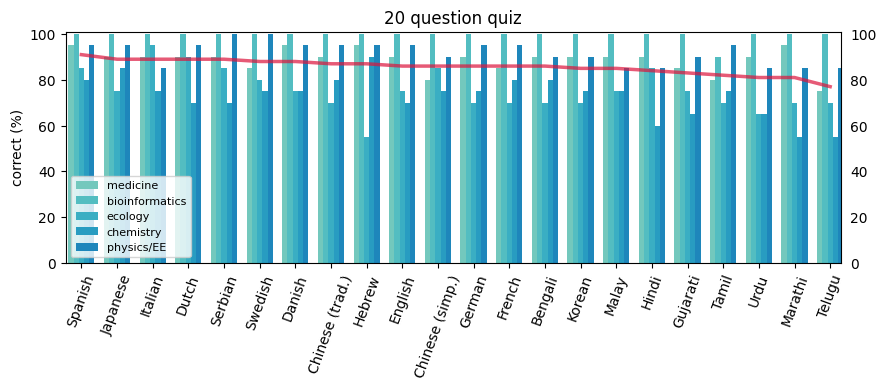

['Chinese (trad.)', 'Gujarati', 'Serbian', 'Hindi', 'Dutch', 'German', 'Italian', 'Chinese (simp.)', 'Japanese', 'French', 'Marathi', 'Swedish', 'Danish', 'English', 'Bengali', 'Spanish', 'Hebrew', 'Malay', 'Korean', 'Telugu', 'Urdu', 'Tamil']
[97.0, 97.0, 96.0, 95.0, 95.0, 94.0, 94.0, 93.0, 93.0, 93.0, 93.0, 93.0, 93.0, 92.0, 92.0, 92.0, 92.0, 92.0, 91.0, 91.0, 90.0, 90.0]


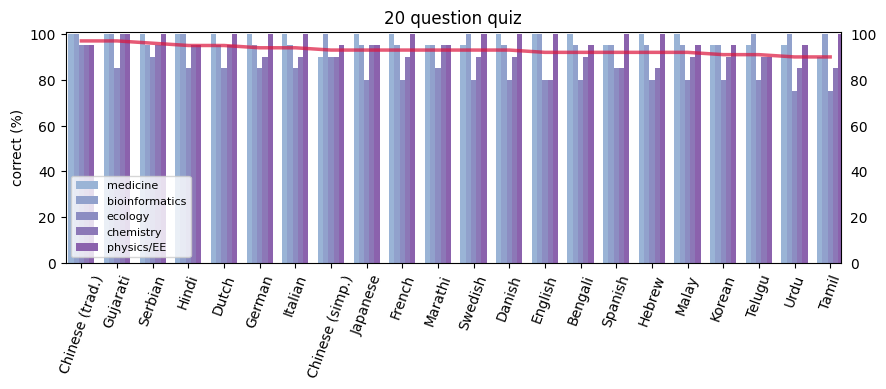

['Chinese (trad.)', 'Japanese', 'English', 'Bengali', 'Italian', 'French', 'Korean', 'Hindi', 'Marathi', 'Malay', 'German', 'Telugu', 'Gujarati', 'Spanish', 'Dutch', 'Hebrew', 'Swedish', 'Urdu', 'Tamil', 'Serbian', 'Danish', 'Chinese (simp.)']
[96.0, 95.0, 94.0, 94.0, 94.0, 93.0, 93.0, 93.0, 93.0, 93.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 91.0, 90.0, 90.0, 90.0, 89.0, 87.0]


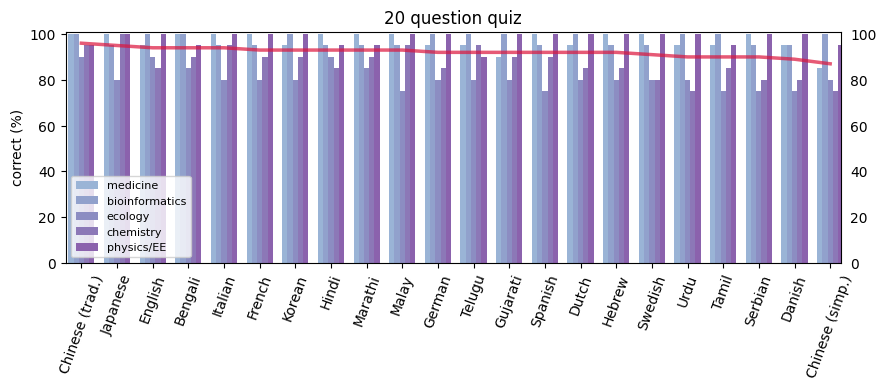

In [10]:
# figures/tables questions only!

plot_quiz(["20q_temp0_figs/temp0"], [plt.cm.YlGnBu], plot_avg=True)
plot_quiz(["20q_temp0_figs/temp1"], [plt.cm.YlGnBu], plot_avg=True)
plot_quiz(["20q_temp1_figs/temp0"], [plt.cm.BuPu], plot_avg=True)
plot_quiz(["20q_temp1_figs/temp1"], [plt.cm.BuPu], plot_avg=True)

[0.9090909090909091, 0.045454545454545456, 0.8181818181818182, 1.0, 0.6818181818181818]


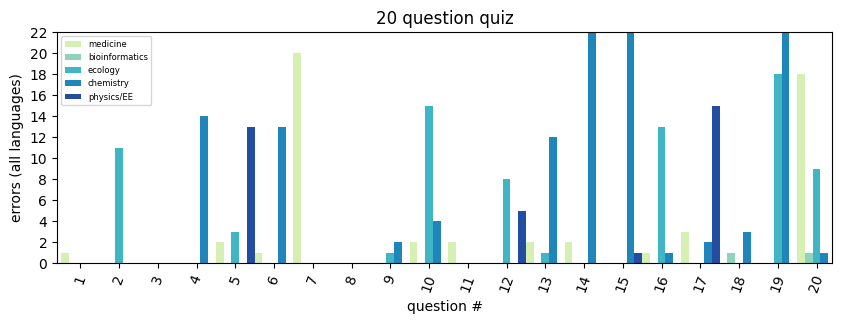

[0.9545454545454546, 0.045454545454545456, 0.7272727272727273, 1.0, 0.6363636363636364]


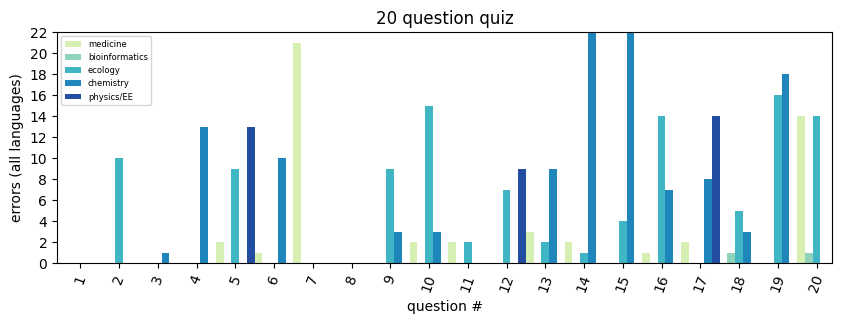

[0.13636363636363635, 0.5909090909090909, 1.0, 0.8181818181818182, 0.3181818181818182]


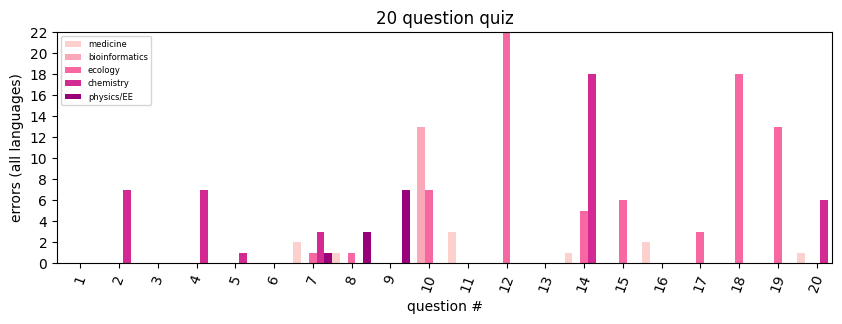

[0.22727272727272727, 0.5, 1.0, 0.7272727272727273, 0.18181818181818182]


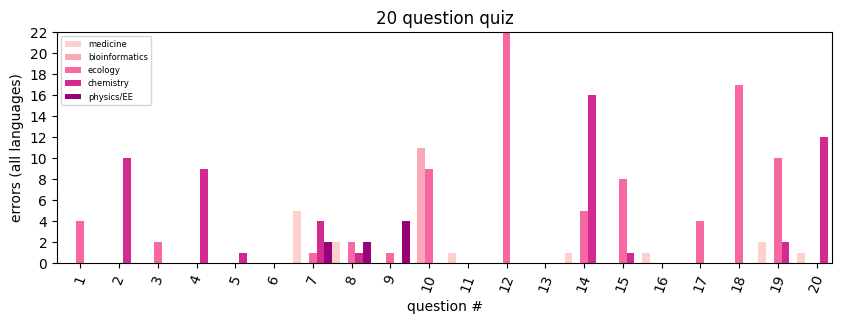

In [11]:
plot_q_stats("20q_temp0_figs/temp0", plt.cm.YlGnBu)
plot_q_stats("20q_temp0_figs/temp1", plt.cm.YlGnBu)
plot_q_stats("20q_temp1_figs/temp0", plt.cm.RdPu)
plot_q_stats("20q_temp1_figs/temp1", plt.cm.RdPu)